In [ ]:
from google.colab import files
uploaded = files.upload()

Saving hdbscan_training_datav2.json to hdbscan_training_datav2.json


In [ ]:
import json

with open("hdbscan_training_datav2.json", "r") as f:
    data = json.load(f)

print("Total records:", len(data))
print("\nTop 10 records:\n")

for i, row in enumerate(data[:10]):
    print(f"{i+1}.", row)

Total records: 10000

Top 10 records:

1. {'case_id': 'CASE-20260214-FRAUDRING-001', 'alerts': [{'alert_id': 'ALERT-FR-000', 'event_time': '2026-03-03 11:20:43', 'txn_id': 'TXN-00000', 'user_id': 'UFR2', 'human_interpretation': 'FP', 'detector_type': 'BEHAVIOR', 'signal': 'Monetary Deviation', 'severity': 'HIGH', 'confidence': '0.854198268810753', 'evidence': [{'risk_category': 'Monetary Deviation', 'feature': 'mod_z_score_abs', 'impact': 'reduced', 'contribution': 0.380739533664993, 'explanation': 'mod_z_score_abs reduced with contribution 0.38.'}, {'risk_category': 'Liquidity Shift', 'feature': 'net_flow_1d', 'impact': 'reduced', 'contribution': 0.191749981472621, 'explanation': 'net_flow_1d reduced with contribution 0.19.'}]}, {'alert_id': 'ALERT-FR-001', 'event_time': '2026-03-03 11:16:50', 'txn_id': 'TXN-00001', 'user_id': 'UFR5', 'human_interpretation': 'TP', 'detector_type': 'BEHAVIOR', 'signal': 'Monetary Deviation', 'severity': 'HIGH', 'confidence': '0.905522804725949', 'evide

In [ ]:
import numpy as np
import hdbscan
from hdbscan import prediction
import umap
import matplotlib.pyplot as plt
from collections import Counter

# Configuration
FEATURE_COLUMNS = [
    "mod_z_score_abs", "ewma_resid", "net_flow_1d",
    "gap_log", "login_count_1h", "failed_login_ratio_1h",
    "new_ip_1d", "is_cross_border"
]
SEVERITY_MAP = {"LOW": 0.1, "MEDIUM": 0.5, "HIGH": 1.0}

class CasePatternEngine:
    def __init__(self, feature_list):
        self.feature_list = feature_list
        self.feature_to_idx = {f: i for i, f in enumerate(feature_list)}
        self.database = []

    def _alerts_to_case_vector(self, alerts):
        """Aggregates multiple alerts into ONE vector representing the case."""
        vec = np.zeros(len(self.feature_list) + 3, dtype=float)
        max_sev, max_conf = 0.0, 0.0

        for a in alerts:
            for item in a.get("evidence", []):
                f = item.get("feature")
                if f in self.feature_to_idx:
                    idx = self.feature_to_idx[f]
                    vec[idx] += float(item.get("contribution", 0.0))

            s_val = SEVERITY_MAP.get(a.get("severity", "LOW"), 0.1)
            if s_val > max_sev: max_sev = s_val
            c_val = float(a.get("confidence", 0.0))
            if c_val > max_conf: max_conf = c_val

        vec[-3], vec[-2], vec[-1] = max_sev, max_conf, len(alerts)
        norm = np.linalg.norm(vec)
        return vec / norm if norm > 0 else vec

    def add_case_to_history(self, case_id, alerts):
        """
        Processes a case and assigns a single label based on Priority of Truth.
        Priority: TP > FN > FP > TN > NP
        """
        # 1. Extract and normalize all labels in the case
        raw_labels = [str(a.get("human_interpretation", "NP")).upper() for a in alerts]

        # 2. Apply Priority Logic
        if "TP" in raw_labels:
            final_label = "TP"
        elif "FN" in raw_labels:
            final_label = "FN"
        elif "FP" in raw_labels:
            final_label = "FP"
        elif "TN" in raw_labels:
            final_label = "TN"
        else:
            final_label = "NP"

        # 3. Store in database
        self.database.append({
            "case_id": case_id,
            "vector": self._alerts_to_case_vector(alerts),
            "label": final_label,
            "all_labels": raw_labels, # Kept for audit/transparency
            "alert_count": len(alerts)
        })

# Initialize and Load
case_engine = CasePatternEngine(FEATURE_COLUMNS)
for entry in data:
    case_engine.add_case_to_history(entry.get("case_id"), entry.get("alerts", []))

# --- Initialize Engine ---
case_engine = CasePatternEngine(FEATURE_COLUMNS)

# --- Load Data from JSON (Grouped by Case) ---
for entry in data:
    case_id = entry.get("case_id")
    alerts = entry.get("alerts", [])
    if alerts:
        case_engine.add_case_to_history(case_id, alerts)

print(f"Loaded {len(case_engine.database)} historical cases.")

Loaded 10000 historical cases.


In [ ]:
from collections import Counter

# Count final labels
stats = Counter([e['label'] for e in case_engine.database])

print("--- Case Labeling Distribution (Prioritized) ---")
for label in ["TP", "FN", "FP", "TN", "NP"]:
    print(f"{label}: {stats.get(label, 0)} cases")

print("\n--- Mixed Case Resolution Example ---")
# Specifically find the case you mentioned earlier
example_id = "CASE-20260214-FRAUDRING-001"
for e in case_engine.database:
    if e['case_id'] == example_id:
        print(f"Case ID: {e['case_id']}")
        print(f"Alert Labels found: {e['all_labels']}")
        print(f"Final Prioritized Label: {e['label']} (Correct!)")

--- Case Labeling Distribution (Prioritized) ---
TP: 6673 cases
FN: 1247 cases
FP: 1327 cases
TN: 753 cases
NP: 0 cases

--- Mixed Case Resolution Example ---
Case ID: CASE-20260214-FRAUDRING-001
Alert Labels found: ['FP', 'TP']
Final Prioritized Label: TP (Correct!)


In [ ]:
# 1. Prepare Training Matrix
X_cases = np.vstack([e["vector"] for e in case_engine.database])

case_clusterer = hdbscan.HDBSCAN(
    # Increase this! If you have thousands of cases,
    # try 30, 50, or even 100 to catch the big islands.
    min_cluster_size=50,

    # min_samples should usually be smaller than min_cluster_size
    min_samples=10,

    prediction_data=True
)

case_clusterer.fit(X_cases) # Or X_cases_2d if you want it to match the plot exactly

unique_labels = set(case_clusterer.labels_)
n_clusters = len([l for l in unique_labels if l != -1])
print(f"Total unique clusters found: {n_clusters}")


print(f"New Cluster Count: {len(set(case_clusterer.labels_) - {-1})}")
case_clusterer.fit(X_cases)

# 3. Create UMAP Projection for Cases
case_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_cases_2d = case_reducer.fit_transform(X_cases)

# Update database with cluster IDs
for i, entry in enumerate(case_engine.database):
    entry["cluster_id"] = int(case_clusterer.labels_[i])

Total unique clusters found: 2
New Cluster Count: 2


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [56]:
# A new case containing two related alerts
new_case_input = {
    "case_id": "NEW-CASE-999",
    "alerts": [
        {
            "signal": "Monetary Deviation",
            "severity": "HIGH",
            "confidence": 0.85,
            "evidence": [{"feature": "mod_z_score_abs", "contribution": 0.4}]
        },
        {
            "signal": "Velocity Spike",
            "severity": "MEDIUM",
            "confidence": 0.70,
            "evidence": [{"feature": "login_count_1h", "contribution": 0.5}]
        }
    ]
}

# new_case_input = {
#     "case_id": "NEW-CASE-999",
#     "alerts": [
#       {
#         "alert_id": "ALERT-OP-000",
#         "event_time": "2026-03-03 16:07:46",
#         "txn_id": "TXN-00000",
#         "user_id": "UOT5",
#         "human_interpretation": "TP",
#         "detector_type": "BEHAVIOR",
#         "signal": "Geographic Risk",
#         "severity": "LOW",
#         "confidence": "0.920813783945063",
#         "evidence": [
#           {
#             "risk_category": "Geographic Risk",
#             "feature": "is_cross_border",
#             "impact": "increased",
#             "contribution": 0.36476414169694,
#             "explanation": "is_cross_border increased with contribution 0.36."
#           },
#           {
#             "risk_category": "Liquidity Shift",
#             "feature": "net_flow_1d",
#             "impact": "reduced",
#             "contribution": -0.34279505600187,
#             "explanation": "net_flow_1d reduced with contribution -0.34."
#           }
#         ]
#       },
#       {
#         "alert_id": "ALERT-OP-001",
#         "event_time": "2026-03-03 16:25:31",
#         "txn_id": "TXN-00001",
#         "user_id": "UOT3",
#         "human_interpretation": "TP",
#         "detector_type": "BEHAVIOR",
#         "signal": "Access Risk",
#         "severity": "MEDIUM",
#         "confidence": "0.949385818028118",
#         "evidence": [
#           {
#             "risk_category": "Access Risk",
#             "feature": "failed_login_ratio_1h",
#             "impact": "increased",
#             "contribution": 0.153787819900475,
#             "explanation": "failed_login_ratio_1h increased with contribution 0.15."
#           },
#           {
#             "risk_category": "Geographic Risk",
#             "feature": "is_cross_border",
#             "impact": "reduced",
#             "contribution": -0.481062841016772,
#             "explanation": "is_cross_border reduced with contribution -0.48."
#           }
#         ]
#       }
#     ]
#   }



# 1. Vectorize the new case
new_case_vec = case_engine._alerts_to_case_vector(new_case_input["alerts"])
new_case_X = np.array([new_case_vec])

# 2. Project into UMAP space
new_case_2d = case_reducer.transform(new_case_X)

# 3. Predict Cluster
case_preds, case_strengths = prediction.approximate_predict(case_clusterer, new_case_X)
print(f"New Case belongs to Cluster: {case_preds[0]}")

New Case belongs to Cluster: 1


In [57]:
# Get unique labels from the clusterer
unique_labels = set(case_clusterer.labels_)

# Count how many are actual clusters (exclude -1)
n_clusters = len([l for l in unique_labels if l != -1])
has_noise = -1 in unique_labels

print(f"Total unique clusters found: {n_clusters}")
if has_noise:
    print("Note: Outliers (noise) were also detected and labeled as -1.")

# Your existing prediction print
print(f"New Case predicted cluster: {case_preds[0]}")

Total unique clusters found: 2
Note: Outliers (noise) were also detected and labeled as -1.
New Case predicted cluster: 1


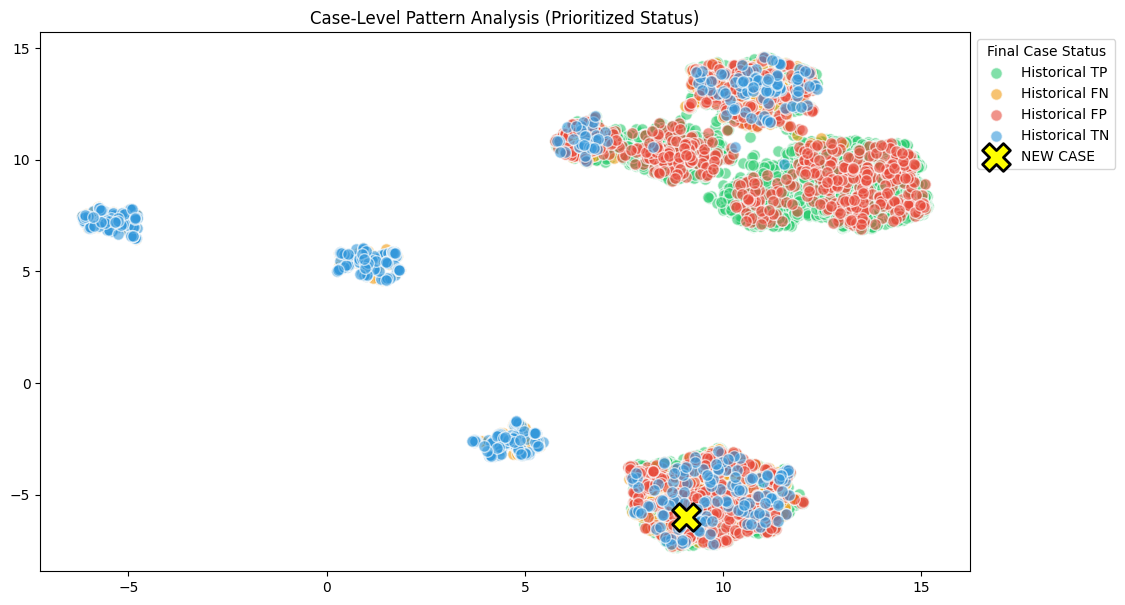

In [58]:
plt.figure(figsize=(12, 7))

# 4 Core Categories + NP
color_map = {
    "TP": "#2ecc71", # Green (Fraud Found)
    "FN": "#f39c12", # Orange (Fraud Missed)
    "FP": "#e74c3c", # Red (False Alarm)
    "TN": "#3498db", # Blue (Legit)
    "NP": "#95a5a6"  # Gray (Unknown)
}

case_labels = [e["label"] for e in case_engine.database]

for l_type, color in color_map.items():
    idxs = [i for i, label in enumerate(case_labels) if label == l_type]
    if idxs:
        plt.scatter(
            X_cases_2d[idxs, 0], X_cases_2d[idxs, 1],
            c=color, label=f"Historical {l_type}",
            alpha=0.6, s=70, edgecolors='white'
        )

# Plot New Case
plt.scatter(
    new_case_2d[:, 0], new_case_2d[:, 1],
    c='yellow', marker='X', s=400, edgecolor='black',
    linewidth=2, label="NEW CASE", zorder=20
)

plt.title("Case-Level Pattern Analysis (Prioritized Status)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Final Case Status")
plt.show()

In [59]:
def classify_new_case(new_case_vec, engine, clusterer, k=5):
    # 1. Get HDBSCAN Cluster Prediction
    new_X = np.array([new_case_vec])
    pred_labels, strengths = prediction.approximate_predict(clusterer, new_X)
    cluster_id = int(pred_labels[0])
    conf = float(strengths[0])

    # 2. Find K-Nearest Neighbors for label consensus
    # (Using cosine similarity)
    V = np.vstack([e["vector"] for e in engine.database])
    similarities = V.dot(new_case_vec.ravel())
    top_indices = np.argsort(-similarities)[:k]

    neighbor_labels = [engine.database[i]["label"] for i in top_indices]
    label_counts = Counter(neighbor_labels)
    most_common_label = label_counts.most_common(1)[0][0]

    print(f"--- Analysis for Case: {new_case_input['case_id']} ---")
    print(f"Predicted Cluster: {cluster_id} (Confidence: {conf:.2%})")
    print(f"Closest Historical Neighbors: {neighbor_labels}")
    print(f"\nCONCLUSION:")

    if cluster_id != -1:
        print(f"This case lands in a known pattern cluster associated with: {most_common_label}")
    else:
        print(f"This case is an OUTLIER (Noise), but most resembles: {most_common_label}")

    if most_common_label == "TP":
        print("ACTION: HIGH PRIORITY - Similarity to known Fraud Patterns.")
    elif most_common_label == "FP":
        print("ACTION: LOW PRIORITY - Similarity to known False Positives.")
    else:
        print("ACTION: NEUTRAL - Requires manual review.")

# Run the classification
classify_new_case(new_case_vec, case_engine, case_clusterer)

--- Analysis for Case: NEW-CASE-999 ---
Predicted Cluster: 1 (Confidence: 96.61%)
Closest Historical Neighbors: ['TP', 'TP', 'TP', 'FN', 'FN']

CONCLUSION:
This case lands in a known pattern cluster associated with: TP
ACTION: HIGH PRIORITY - Similarity to known Fraud Patterns.
